# First Look at the incoming saildrone data

## ADCP

In [1]:
import xarray as xr

In [2]:
ds = xr.open_dataset("~/shared_data/incoming_bfiedler/ADCP/SailDrone_SD1030_MOSES_2019/adcp/netcdf/saildrone-gen_5-atlantic_to_med_2019_to_2020-sd1030-20200201T000000-20200201T235959-5_minutes-v1.1580603508805.nc")
ds

<xarray.Dataset>
Dimensions:              (trajectory: 1, cell_depth: 50, obs: 288, beam: 4)
Coordinates:
  * trajectory           (trajectory) int64 1030
  * cell_depth           (cell_depth) float64 4.2 6.2 8.2 ... 98.2 100.2 102.2
    time                 (trajectory, obs) datetime64[ns] ...
    latitude             (trajectory, obs) float64 ...
    longitude            (trajectory, obs) float64 ...
Dimensions without coordinates: obs, beam
Data variables: (12/28)
    roll                 (trajectory, obs) float64 ...
    pitch                (trajectory, obs) float64 ...
    heading              (trajectory, obs) float64 ...
    vel_east             (trajectory, obs, cell_depth) float64 ...
    vel_north            (trajectory, obs, cell_depth) float64 ...
    vel_up               (trajectory, obs, cell_depth) float64 ...
    ...                   ...
    bt_vel_up            (trajectory, obs) float64 ...
    bt_amp               (trajectory, obs, beam) float64 ...
    bt_percent_good      (trajectory, obs, beam) float64 ...
    percent_good_4_beam  (trajectory, obs, cell_depth) float64 ...
    percent_good_3_beam  (trajectory, obs, cell_depth) float64 ...
    percent_good         (trajectory, obs, cell_depth) float64 ...
Attributes: (12/38)
    description:                     Saildrone NetCDF Format
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    keywords:                        ADCP,Saildrone
    geospatial_vertical_units:       meters
    geospatial_lon_units:            degrees_east
    geospatial_lat_units:            degrees_north
    ...                              ...
    geospatial_lat_max:              29.360221792012453
    geospatial_lon_min:              -17.66750714275986
    geospatial_lon_max:              -17.66680620610714
    geospatial_vertical_positive:    down
    wmo_id:                          5801955
    license:                         2019 (c) SAILDRONE Inc.  All Rights Rese...

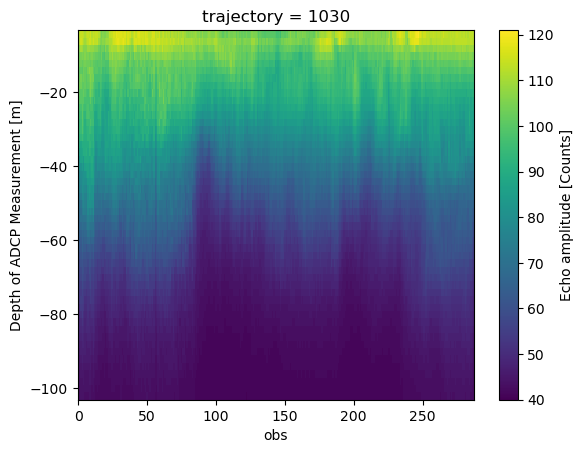

In [3]:
ds.assign_coords(z=-ds.cell_depth).echo_intensity.isel(trajectory=0, beam=0).T.plot(y="z")

## Echosounder - Track

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv(
    "~/shared_data/incoming_bfiedler/biomass_hydroacoustics/SailDrone_SD1053_MOSES_2019/echosounder/saildrone-gen_5-atlantic_to_med_2019_to_2020-sd1053-gps-1_minutes-v1.1603752016835.csv",
)
df["Datetime"] = pd.to_datetime(list(map(lambda dt: f"{dt[0]}T{dt[1]}", zip(df.GPS_date, df.GPS_time))))
df = df.set_index("Datetime")
df

,GPS_date,GPS_time,Latitude,Longitude
Datetime,,,,
2019-11-01 00:00:00,2019-11-01,00:00:00,21.353680,-22.581008
2019-11-01 00:01:00,2019-11-01,00:01:00,21.352816,-22.581502
2019-11-01 00:02:00,2019-11-01,00:02:00,21.351867,-22.582013
2019-11-01 00:03:00,2019-11-01,00:03:00,21.350941,-22.582426
2019-11-01 00:04:00,2019-11-01,00:04:00,21.350010,-22.582922
...,...,...,...,...
2020-07-17 23:55:00,2020-07-17,23:55:00,45.655366,13.767331
2020-07-17 23:56:00,2020-07-17,23:56:00,45.655373,13.767323
2020-07-17 23:57:00,2020-07-17,23:57:00,45.655363,13.767336


In [6]:
import cartopy
from matplotlib import pyplot as plt

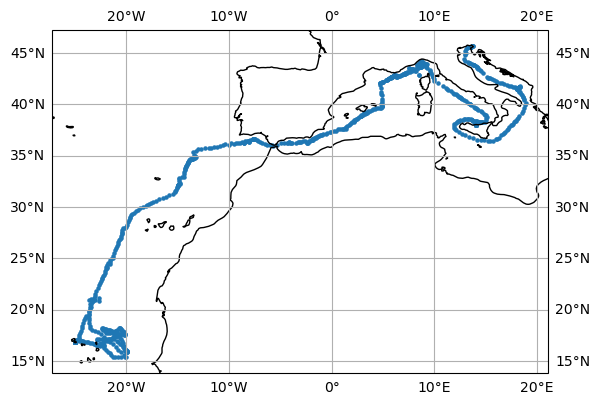

In [7]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": cartopy.crs.PlateCarree()})

df[["Latitude", "Longitude"]].resample("6H").median().plot.scatter(
    y="Latitude", x="Longitude", s=5,
    ax=ax, transform=cartopy.crs.PlateCarree(),
)

ax.coastlines();
# ax.set_extent([-20, 50, -30, 30])
ax.gridlines(draw_labels=True);

## Echosounder - Profile Data

In [8]:
# %pip install echopype

In [9]:
import echopype as ep
import warnings

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ep_raw = ep.open_raw(
        "/home/jovyan/shared_data/incoming_bfiedler/biomass_hydroacoustics/SailDrone_SD1053_MOSES_2019/echosounder/raw/SD2019_ATL2MED_v04-Phase0-D20191103-T035959-0.raw",
        sonar_model="EK80",
    )

In [11]:
ep_raw["Sonar/Beam_group1"]

<xarray.Dataset>
Dimensions:                        (channel: 2, ping_time: 893,
                                    range_sample: 4600, beam: 3)
Coordinates:
  * channel                        (channel) <U29 'EKA 266977-07 ES38-18|200-...
  * ping_time                      (ping_time) datetime64[ns] 2019-11-03T04:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 4597 4598 4599
  * beam                           (beam) <U21 '1' '2' '3'
Data variables: (12/26)
    frequency_nominal              (channel) float64 3.8e+04 2e+05
    beam_type                      (channel) int64 17 0
    beamwidth_twoway_alongship     (channel) float64 17.1 17.3
    beamwidth_twoway_athwartship   (channel) float64 17.1 16.9
    beam_direction_x               (channel) float64 nan nan
    beam_direction_y               (channel) float64 nan nan
    ...                             ...
    transmit_power                 (channel, ping_time) float64 500.0 ... 215.0
    transmit_duration_nominal      (channel, ping_time) float32 0.001024 ... ...
    slope                          (channel, ping_time) float64 0.1028 ... 0....
    channel_mode                   (channel, ping_time) int8 0 0 0 0 ... 0 0 0 0
    transmit_type                  (channel, ping_time) <U3 'CW' 'CW' ... 'CW'
    sample_time_offset             (channel, ping_time) float64 0.0 0.0 ... 0.0
Attributes:
    beam_mode:              vertical
    conversion_equation_t:  type_3